# Integration of Skynet models into Seisbench
### Small details will differ due to slight differences in the implementation, but qualitatively they are consistent.
### As shown below, the picks differ by a fraction of a second, I will look into it but for now it works well.

In [1]:
import torch
import skynet
import pandas as pd
import matplotlib.pyplot as plt

from seisbench.models.skynet import Skynet

from obspy import read
from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime as UT

In [2]:
# load the model the skynet way
original_skynet  = skynet.Regional_Picker(in_channels=3,out_channels=3)
original_skynet.load_state_dict(torch.load('/Users/albert/Pn/skynet_models/regional_picker',map_location='cpu'))

<All keys matched successfully>

When loading the model from seisbench, a couple of details are changed to match the original implementation, like the component order

In [3]:
# load the model the seisbench way
seisbench_skynet = Skynet(component_order='ENZ')
seisbench_skynet.load_state_dict(torch.load('/Users/albert/Pn/skynet_models/regional_picker',map_location='cpu'))

<All keys matched successfully>

In [4]:
# ensure the models are set to eval mode
seisbench_skynet.eval()
original_skynet.eval()

Regional_Picker(
  (conv1): Conv1d(3, 8, kernel_size=(7,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(8, 8, kernel_size=(7,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(8, 8, kernel_size=(7,), stride=(4,), padding=(3,))
  (bn3): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(8, 11, kernel_size=(7,), stride=(1,), padding=same)
  (bn4): BatchNorm1d(11, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv1d(11, 11, kernel_size=(7,), stride=(4,), padding=(3,))
  (bn5): BatchNorm1d(11, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv1d(11, 16, kernel_size=(7,), stride=(1,), padding=same)
  (bn6): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (conv7): Conv1d(16, 16, kernel_

In [5]:
client = Client('IRIS')

 Get some example waveforms from an earthquake recorded a few hundred kilometers away

In [6]:
st = client.get_waveforms('LD','WVNY','*','HH?',UT('2024-04-05T14:23:00.005000Z'),
                         UT('2024-04-05T14:23:00.005000Z')+300-0.01)

In [7]:
seisbench_predictions = seisbench_skynet.annotate(st)
skynet_predictions    = skynet.predict_from_stream(st,original_skynet).detach().numpy()

Text(1000, 0.5, 'Noise')

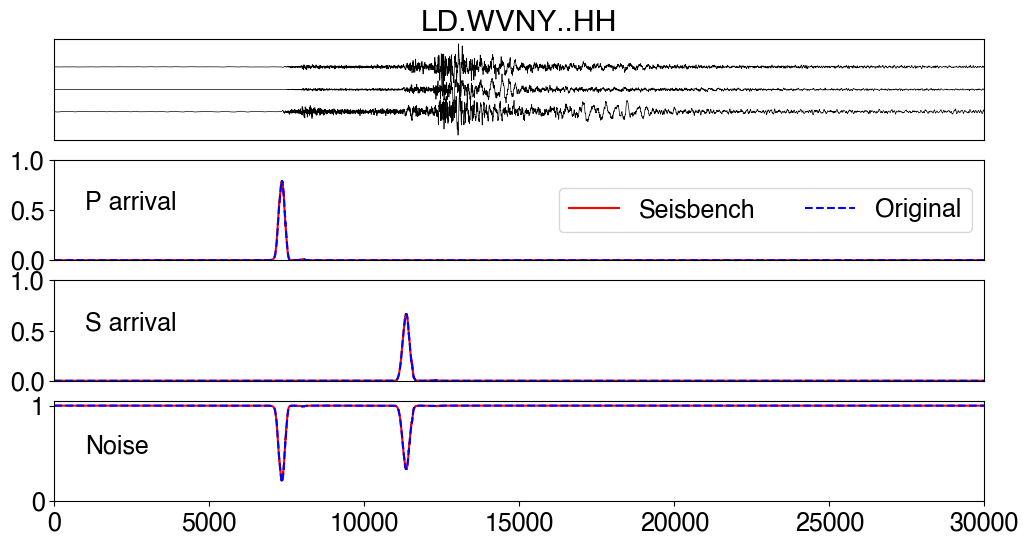

In [8]:
plt.figure(figsize=(12,6))

plt.subplot(4,1,1)
for i,tr in enumerate(st):
    plt.plot(tr.normalize().data-i,color='k',linewidth=0.5)

plt.xlim(0,30000);plt.xticks([]);plt.yticks([])
plt.title(tr.id[:-1])

plt.subplot(4,1,2)
plt.plot(seisbench_predictions[0].data,color='red',label='Seisbench')
plt.plot(skynet_predictions[0,0,:],color='blue',linestyle='--',label='Original')
plt.xlim(0,30000);plt.ylim(0,1);plt.xticks([]);plt.legend(ncol=2,loc='right')
plt.text(1000,0.5,'P arrival')

plt.subplot(4,1,3)
plt.plot(seisbench_predictions[1].data,color='red')
plt.plot(skynet_predictions[0,1,:],'--',color='blue')
plt.xlim(0,30000);plt.ylim(0,1);plt.xticks([])
plt.text(1000,0.5,'S arrival')

plt.subplot(4,1,4)
plt.plot(seisbench_predictions[2].data,color='red')
plt.plot(skynet_predictions[0,2,:],'--',color='blue')
plt.xlim(0,30000);plt.ylim(0,1.05)
plt.text(1000,0.5,'Noise')


Repeat for another earthquake

In [9]:
st = client.get_waveforms('NN','PAH','*','HH?',UT('2024-03-11T11:47:00.000470Z'),
                         UT('2024-03-11T11:47:00.000470Z')+300)

In [10]:
seisbench_predictions = seisbench_skynet.annotate(st)
skynet_predictions    = skynet.predict_from_stream(st,original_skynet).detach().numpy()

Filter the waveforms for visualization, but bear in mind that the predictions were performed using the data in its raw form.

In [11]:
tst= st.copy()
tst=tst.detrend('demean')
tst=tst.taper(0.01)
tst=tst.filter('bandpass',freqmin=1,freqmax=20)

Text(1000, 0.5, 'Noise')

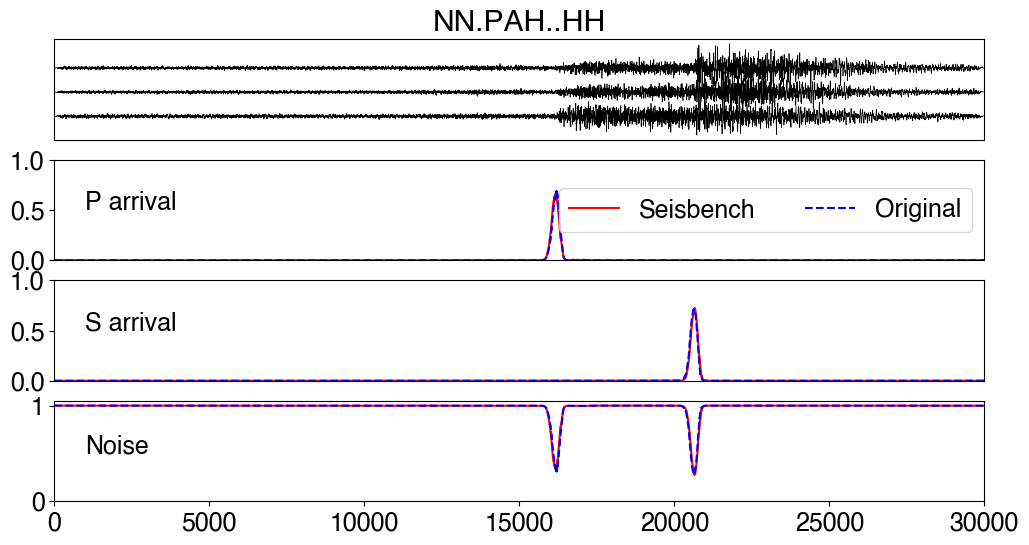

In [12]:
plt.figure(figsize=(12,6))

plt.subplot(4,1,1)
for i,tr in enumerate(tst):
    plt.plot(tr.normalize().data-i,color='k',linewidth=0.5)

plt.xlim(0,30000);plt.xticks([]);plt.yticks([])
plt.title(tr.id[:-1])

plt.subplot(4,1,2)
plt.plot(seisbench_predictions[0].data,color='red',label='Seisbench')
plt.plot(skynet_predictions[0,0,:],color='blue',linestyle='--',label='Original')
plt.xlim(0,30000);plt.ylim(0,1);plt.xticks([]);plt.legend(ncol=2,loc='right')
plt.text(1000,0.5,'P arrival')

plt.subplot(4,1,3)
plt.plot(seisbench_predictions[1].data,color='red')
plt.plot(skynet_predictions[0,1,:],'--',color='blue')
plt.xlim(0,30000);plt.ylim(0,1);plt.xticks([])
plt.text(1000,0.5,'S arrival')

plt.subplot(4,1,4)
plt.plot(seisbench_predictions[2].data,color='red')
plt.plot(skynet_predictions[0,2,:],'--',color='blue')
plt.xlim(0,30000);plt.ylim(0,1.05)
plt.text(1000,0.5,'Noise')


In [13]:
# Test the functions that produce the picks

In [14]:
# test the classify function
seisbench_skynet.classify(st)

namespace(creator='Skynet',
          picks=PickList with 2 entries:
                
                NN.PAH.	2024-03-11T11:49:41.783100Z	P
                NN.PAH.	2024-03-11T11:50:26.623100Z	S)

In [15]:
picks=skynet.execute(st,original_skynet,outname='test_picks.csv',stack=False)
print(picks)

Saved results in test_picks.csv, 2 picks.
  network station                         time     score phase
0      NN     PAH  2024-03-11T11:49:41.943100Z  0.686314     P
0      NN     PAH  2024-03-11T11:50:26.393100Z  0.711148     S


# Integrating the multiphase picker
## Caution is advised when using this model, it has been trained on very little data, see Section 6 of the paper
### The class is the same as in the previous examples, but we change the number of output classes from 3 to 5, one for Pn, Pg, Sn, Sg, and noise.

In [24]:
multiphase_skynet = Skynet(in_channels=3,classes=5,phases=["Pn","Pg","Sn","Sg","noise"],
                          component_order='ENZ')
multiphase_skynet.load_state_dict(torch.load('/Users/albert/Pn/skynet_models/multiphase_updated',map_location='cpu'))

<All keys matched successfully>

In [17]:
st = client.get_waveforms('LD','WVNY','*','HH?',UT('2024-04-05T14:23:00.005000Z'),
                         UT('2024-04-05T14:23:00.005000Z')+300-0.01)

In [18]:
multiphase_predictions = multiphase_skynet.annotate(st)

In [19]:
multiphase_predictions

5 Trace(s) in Stream:
LD.WVNY..Skynet_Pn    | 2024-04-05T14:23:00.005000Z - 2024-04-05T14:27:59.995000Z | 100.0 Hz, 30000 samples
LD.WVNY..Skynet_Pg    | 2024-04-05T14:23:00.005000Z - 2024-04-05T14:27:59.995000Z | 100.0 Hz, 30000 samples
LD.WVNY..Skynet_Sn    | 2024-04-05T14:23:00.005000Z - 2024-04-05T14:27:59.995000Z | 100.0 Hz, 30000 samples
LD.WVNY..Skynet_Sg    | 2024-04-05T14:23:00.005000Z - 2024-04-05T14:27:59.995000Z | 100.0 Hz, 30000 samples
LD.WVNY..Skynet_noise | 2024-04-05T14:23:00.005000Z - 2024-04-05T14:27:59.995000Z | 100.0 Hz, 30000 samples

(0.0, 1.0)

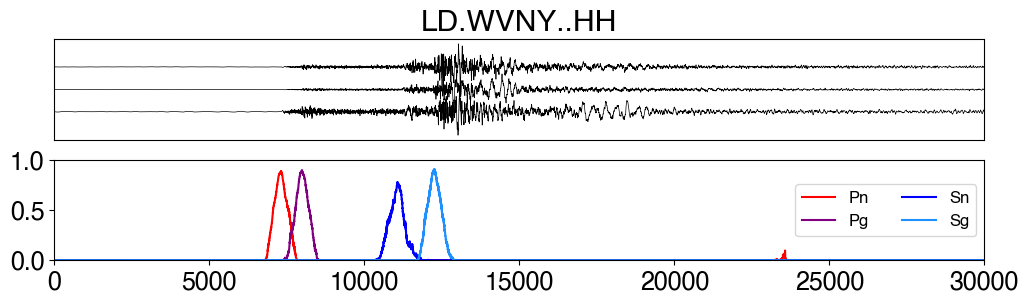

In [20]:
plt.figure(figsize=(12,6))

plt.subplot(4,1,1)
for i,tr in enumerate(st):
    plt.plot(tr.normalize().data-i,color='k',linewidth=0.5)

plt.xlim(0,30000);plt.xticks([]);plt.yticks([])
plt.title(tr.id[:-1])
plt.subplot(4,1,2)

colors=['red','purple','blue','dodgerblue']
labels=['Pn','Pg','Sn','Sg']
for i in range(4):
    plt.plot(multiphase_predictions[i].data,label=labels[i],color=colors[i])

plt.legend(loc='right',fontsize=12,ncol=2)
plt.xlim(0,30000);plt.ylim(0,1)

In [ ]:
Save the models using seisbench.save

In [21]:
seisbench_skynet.save('seisbench_skynet')

In [25]:
multiphase_skynet.save('multiphase_skynet')

In [23]:
!pwd

/Users/albert/seisbench
